# グラフ彩色問題

こちらでは、[Lucas, 2014, "Ising formulations of many NP problems"](https://doi.org/10.3389/fphy.2014.00005)の 6.1. Graph Coloring を OpenJij と [JijModeling](https://www.ref.documentation.jijzept.com/jijmodeling/)、そしてommx-openjij-adapter を用いて解く方法をご紹介します。

## 概要: グラフ彩色問題とは

グラフ彩色問題とは、あるグラフ上の辺で繋がれた頂点どうしを異なる色になるように彩色する問題です。NP完全な問題として知られています。

### 具体例

下図のように6個の頂点といくつかの辺からなる無向グラフが与えられたとしましょう。

![](../../../assets/graph_coloring_01.png)

これを3色で全ての頂点を塗り分けると以下のようになります。

![](../../../assets/graph_coloring_02.png)

全ての辺において、その両端に位置する頂点は異なる色で塗り分けられていることがわかります。

### 問題の一般化

それではこの問題を一般化し、数式で表現してみましょう。無向グラフ$G = (V, E)$を、辺で結ばれた頂点の色が重複しないように$N$色で塗り分けることを考えます。
頂点の色分けをバイナリ変数$x_{v, n}$で表すことにします。$v$番目の頂点を$n$の色で塗り分けるとき、$x_{v, n} = 1$、それ以外では$x_{v, n} = 0$となります。  

**制約: 頂点はどれか一色で塗り分けなければならない**

例えば、青色と緑色の2色で1つの頂点を塗ることは許されません。これを数式で表現すると、以下のようになります。


$$
\nonumber
\sum_{n=0}^{N-1} x_{v, n} = 1 \quad (\forall v \in V) \tag{1}
$$

**目的関数: 同じ色の頂点を両端に持つ辺の数を最小にする**

グラフ彩色問題の問題設定から、全ての辺の両端の頂点が異なる色で塗り分けられる必要があります。これを数式で表現すると

$$
\nonumber
\min \quad \sum_{n=0}^{N-1} \sum_{(uv) \in E} x_{u, n} x_{v, n} \tag{2}
$$

もし、全ての辺の両端の頂点が異なる色で塗り分けられているなら、この目的関数値はゼロとなります。

## JijModelingによるモデル構築

### 変数定義

式(1), (2)で用いられている変数を、以下のようにして定義しましょう。

In [1]:
import jijmodeling as jm


# define variables
V = jm.Placeholder('V')
E = jm.Placeholder('E', ndim=2)
N = jm.Placeholder('N')
x = jm.BinaryVar('x', shape=(V, N))
n = jm.Element('i', (0, N))
v = jm.Element('v', (0, V))
e = jm.Element('e', E)

`V=jm.Placeholder('V')`でグラフの頂点数、`E=jm.Placeholder('E', ndim=2)`でグラフの辺集合を定義します。
`N=jm.Placeholder('N')`でグラフを塗り分ける色数を定義し、その`V, N`を用いてバイナリ変数$x_{v, n}$を`x=jm.BinaryVar('x', shape=(V, N))`のように定義します。`n, v`はバイナリ変数の添字に用いる変数です。
最後の`e`は辺を表す変数です。`e[0], e[1]`が辺`e`の両端に位置する頂点となります。すなわち$(u, v) = (e[0], e[1])$です。

### 制約の実装

式(1)を実装します。

In [2]:
# set problem
problem = jm.Problem('Graph Coloring')
# set one-hot constraint that each vertex has only one color
problem += jm.Constraint('color', x[v, :].sum()==1, forall=v)

問題を作成し、そこに制約を追加しましょう。`x[v, :].sum()`とすることで`jm.sum(n, x[v, n])`を簡潔に実装することができます。

### 目的関数の追加

式(2)の目的関数を実装しましょう。

In [3]:
# set objective function: minimize edges whose vertices connected by edges are the same color
problem += jm.sum([n, e], x[e[0], n]*x[e[1], n])

`jm.sum([n, e], ...)`とすることで、$\sum_n \sum_e$を表現することができます。`x[e[0], n]`は$x_{e[0], n}$、`x[e[1], n]`は$x_{e[1], n}$を表していいます。  
実際に実装された数式をJupyter Notebookで表示してみましょう。

In [4]:
problem

### インスタンスの作成

実際にグラフ彩色を行うグラフを設定しましょう。

In [5]:
import networkx as nx

# set the number of vertices
inst_V = 12
# set the number of colors
inst_N = 4
# create a random graph
inst_G = nx.gnp_random_graph(inst_V, 0.4)
# get information of edges
inst_E = [list(edge) for edge in inst_G.edges]
instance_data = {'V': inst_V, 'N': inst_N, 'E': inst_E}

今回は次のようなグラフを塗り分けてみましょう。

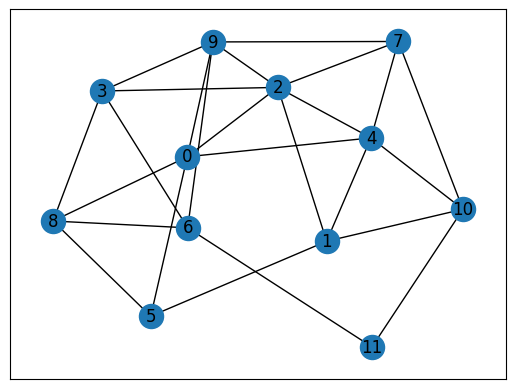

In [6]:
import matplotlib.pyplot as plt

nx.draw_networkx(inst_G, with_labels=True)
plt.show()

### JijModeling transpilerによるPyQUBOへの変換

ここまで行われてきた実装は、全てJijModelingによるものでした。
これを[PyQUBO](https://pyqubo.readthedocs.io/en/latest/)に変換することで、OpenJijはもちろん、他のソルバーを用いた組合せ最適化計算を行うことが可能になります。

In [10]:
import ommx_openjij_adapter as oj_ad
# compile
instance = jm.Interpreter(instance_data).eval_problem(problem)
# get qubo model
qubo, const = instance.to_qubo()

### OpenJijによる最適化計算の実行

今回はOpenJijのシミュレーテッド・アニーリングを用いて、最適化問題を解いてみましょう。

In [11]:
import openjij as oj

# set sampler
sampler = oj.SASampler()
# solve problem
result = sampler.sample_qubo(qubo)

`SASampler`を設定し、そのサンプラーに先程作成したQUBOモデルの`qubo`を入力することで、計算結果が得られます。

### デコードと解の表示

計算結果をデコードします。
また実行可能解の中から目的関数値が最小のものを選び出し、それを可視化してみましょう。

[(0, 1), (1, 1), (2, 2), (3, 1), (4, 0), (5, 0), (6, 0), (7, 1), (8, 2), (9, 3), (10, 2), (11, 1)]


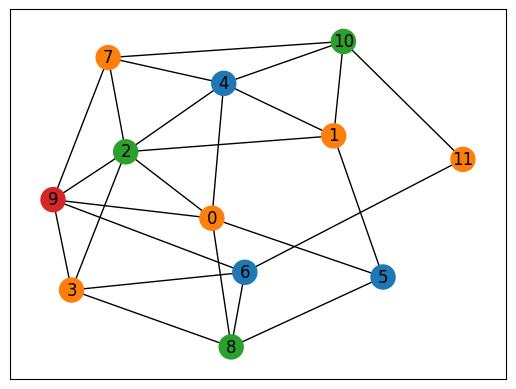

In [18]:
import numpy as np

adapter = oj_ad.OMMXOpenJijSAAdapter(instance)
sampleset = adapter.decode_to_sampleset(result)

# decode a result to JijModeling sampleset
# get feasible samples from sampleset
feasible_sample = sampleset.best_feasible_unrelaxed()
# get the indices of x == 1
x_indices = [subs for subs, value in feasible_sample.extract_decision_variables("x").items() if value == 1]
print(x_indices)
# initialize a list for color of nodes
node_colors = [-1] * instance_data["V"]
# draw the graph
cmap = plt.get_cmap("tab10")
colors = [cmap(i) for i in range(instance_data["N"])]
# fill node_colors list with colors according to solution
for node, color_idx in x_indices:
    node_colors[node] = colors[color_idx]

# draw the colored graph
nx.draw_networkx(inst_G, node_color=node_colors, with_labels=True)
plt.show()